<a href="https://colab.research.google.com/github/MORIMOTO-KOTARO/DataScience_PBL_3/blob/main/DataSciense_PBL%EF%BC%BF3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **RDkitのインストール**

In [ ]:
!pip install --quiet rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 37.6 MB/s eta 0:00:00


### **モジュールのインポート**

In [ ]:
import io

# Google Colab用
from google.colab import files

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### **エクセルのアップロード**

In [ ]:
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"ファイル読み込み成功: {filename}")
    df = pd.read_excel(io.BytesIO(uploaded[filename]))

smiles_col = df.columns[1]
target_col = df.columns[2]

# SMILES文字列や毒性値が空欄の行は、後の処理でエラーになるため取り除きます
df_clean = df[[smiles_col, target_col]].dropna()

print("\n--- 処理対象のデータ ---")
print(df_clean.head())
print("-" * 25)

Saving 新規 Microsoft Excel ワークシート.xlsx to 新規 Microsoft Excel ワークシート.xlsx
ファイル読み込み成功: 新規 Microsoft Excel ワークシート.xlsx

--- 処理対象のデータ ---
                        Washed_smiles  CCRF-CEM
0                   CC1=CC(=O)C=CC1=O    5.5705
1         CCCCCCCCCCCCCCCc1cc(ccc1N)O    7.3320
2  c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3    5.4490
3                CN(C)CCC(=O)c1ccccc1    4.6310
4      Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C    6.6960
-------------------------


### **スマイルズをモーガンフィンガープリントでベクトル化**

In [ ]:
def smiles_to_morgan_fp(smiles, radius=2, nBits=4096):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
            return np.array(list(fp.ToBitString())).astype(int)
        else:
            return None
    except:
        return None

# SMILES列に適用してフィンガープリントを作成
df_clean['morgan_fp'] = df_clean[smiles_col].apply(smiles_to_morgan_fp)

# 不正な SMILES の行を削除
df_final = df_clean.dropna().reset_index(drop=True)

# --- 結果の確認 ---
print(f"\nフィンガープリントの計算が完了しました。")
print(f"データ数: {len(df_final)} 件")

for i in range(5):
    print(f"\n--- 分子 {i+1} ---")
    print(f"SMILES: {df_final[smiles_col][i]}")
    print(f"Morgan FP (最初の30次元のみ表示): {df_final['morgan_fp'][i][:30]}")
    print(f"ベクトルの次元数: {len(df_final['morgan_fp'][i])}")

ストリーミング出力は最後の 5000 行に切り捨てられました。
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION WARNING: please use MorganGenerator
[00:10:43] DEPRECATION W


フィンガープリントの計算が完了しました。
データ数: 46770 件

--- 分子 1 ---
SMILES: CC1=CC(=O)C=CC1=O
Morgan FP (最初の30次元のみ表示): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ベクトルの次元数: 4096

--- 分子 2 ---
SMILES: CCCCCCCCCCCCCCCc1cc(ccc1N)O
Morgan FP (最初の30次元のみ表示): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ベクトルの次元数: 4096

--- 分子 3 ---
SMILES: c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3
Morgan FP (最初の30次元のみ表示): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ベクトルの次元数: 4096

--- 分子 4 ---
SMILES: CN(C)CCC(=O)c1ccccc1
Morgan FP (最初の30次元のみ表示): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ベクトルの次元数: 4096

--- 分子 5 ---
SMILES: Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C
Morgan FP (最初の30次元のみ表示): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ベクトルの次元数: 4096


### **データ下準備**

In [ ]:
# --- 例: 目的変数の列名を指定 ---
target_col = df.columns[2]   # <- 実際の列名に合わせて変更してください

X = np.stack(df_final['morgan_fp'].values)  # Morgan Fingerprint (N_samples, 2048)
y = df_final[target_col].values.astype(np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)

# ===== セル分割ここまで =====


X shape: (46770, 4096)
y shape: (46770,)


### **PyTorch Dataset 定義**

In [ ]:
# ======================================
# 3. PyTorch Dataset 定義
# ======================================
class FingerprintDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = FingerprintDataset(X, y)

# ===== セル分割ここまで =====


### **MLP定義**

In [ ]:
# MLPクラス（隠れ層3層, Dropout強化）
class MLP(nn.Module):
    def __init__(self, input_dim=4096, hidden_dims=[512, 256, 128], dropout=0.3):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))  # 出力層
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### **学習ループ関数の定義**



In [ ]:
def train_one_fold_with_logs(train_loader, val_loader, input_dim=4096, lr=1e-3, epochs=30, device="cuda"):
    model = MLP(input_dim=input_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()

    history = {"train_loss": [], "val_rmse": []}

    best_rmse = float("inf")
    best_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        # バリデーション
        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_preds.append(pred.cpu().numpy())
                val_true.append(yb.cpu().numpy())

        val_preds = np.concatenate(val_preds).ravel()
        val_true  = np.concatenate(val_true).ravel()

        mse = mean_squared_error(val_true, val_preds)
        val_rmse = np.sqrt(mse)

        history["train_loss"].append(train_loss / len(train_loader.dataset))
        history["val_rmse"].append(val_rmse)

        print(f"Epoch {epoch+1}/{epochs}, TrainLoss={history['train_loss'][-1]:.6f}, ValRMSE={val_rmse:.6f}")

        # ベストモデルを保存
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_state = model.state_dict()

    # ベストモデルを復元
    model.load_state_dict(best_state)

    return model, history


### **K-Fold 交差検証**

In [ ]:
rmse_scores, r2_scores = [], []


for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold+1} ===")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_ds = FingerprintDataset(X_train, y_train)
    val_ds   = FingerprintDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

    # 各 fold で「最良の val RMSE」を出したモデルを返す
    model, history = train_one_fold_with_logs(
        train_loader, val_loader, input_dim=X.shape[1], device=device
    )

    # 最終評価
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred = model(xb)
            val_preds.extend(pred.cpu().numpy().flatten().tolist())
            val_true.extend(yb.numpy().flatten().tolist())

    rmse = np.sqrt(mean_squared_error(val_true, val_preds))
    r2   = r2_score(val_true, val_preds)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"Fold {fold+1}: RMSE={rmse:.6f}, R²={r2:.6f}")



=== Fold 1 ===
Epoch 1/30, TrainLoss=2.515238, ValRMSE=0.951614
Epoch 2/30, TrainLoss=0.991335, ValRMSE=0.873639
Epoch 3/30, TrainLoss=0.834218, ValRMSE=0.875635
Epoch 4/30, TrainLoss=0.754949, ValRMSE=0.864436
Epoch 5/30, TrainLoss=0.681022, ValRMSE=0.793955
Epoch 6/30, TrainLoss=0.623865, ValRMSE=0.795067
Epoch 7/30, TrainLoss=0.571818, ValRMSE=0.784759
Epoch 8/30, TrainLoss=0.542722, ValRMSE=0.767823
Epoch 9/30, TrainLoss=0.503457, ValRMSE=0.749423
Epoch 10/30, TrainLoss=0.468327, ValRMSE=0.765447
Epoch 11/30, TrainLoss=0.448141, ValRMSE=0.752481
Epoch 12/30, TrainLoss=0.419275, ValRMSE=0.754862
Epoch 13/30, TrainLoss=0.389393, ValRMSE=0.752049
Epoch 14/30, TrainLoss=0.369272, ValRMSE=0.750561
Epoch 15/30, TrainLoss=0.349766, ValRMSE=0.748893
Epoch 16/30, TrainLoss=0.335989, ValRMSE=0.749578
Epoch 17/30, TrainLoss=0.324934, ValRMSE=0.748569
Epoch 18/30, TrainLoss=0.304617, ValRMSE=0.745797
Epoch 19/30, TrainLoss=0.290366, ValRMSE=0.745171
Epoch 20/30, TrainLoss=0.278820, ValRMSE=0.

### **学習曲線の可視化（1 fold 分）**

Epoch 1/30, TrainLoss=2.801594, ValRMSE=0.950343
Epoch 2/30, TrainLoss=0.988261, ValRMSE=0.886113
Epoch 3/30, TrainLoss=0.844727, ValRMSE=0.846261
Epoch 4/30, TrainLoss=0.752719, ValRMSE=0.826341
Epoch 5/30, TrainLoss=0.680603, ValRMSE=0.782680
Epoch 6/30, TrainLoss=0.641608, ValRMSE=0.778805
Epoch 7/30, TrainLoss=0.583318, ValRMSE=0.771709
Epoch 8/30, TrainLoss=0.539568, ValRMSE=0.763101
Epoch 9/30, TrainLoss=0.502146, ValRMSE=0.759617
Epoch 10/30, TrainLoss=0.478530, ValRMSE=0.759415
Epoch 11/30, TrainLoss=0.444386, ValRMSE=0.758380
Epoch 12/30, TrainLoss=0.422310, ValRMSE=0.755528
Epoch 13/30, TrainLoss=0.392247, ValRMSE=0.763397
Epoch 14/30, TrainLoss=0.368233, ValRMSE=0.764480
Epoch 15/30, TrainLoss=0.358259, ValRMSE=0.755750
Epoch 16/30, TrainLoss=0.339337, ValRMSE=0.749333
Epoch 17/30, TrainLoss=0.326599, ValRMSE=0.760403
Epoch 18/30, TrainLoss=0.313022, ValRMSE=0.759321
Epoch 19/30, TrainLoss=0.297230, ValRMSE=0.769669
Epoch 20/30, TrainLoss=0.286188, ValRMSE=0.748924
Epoch 21/

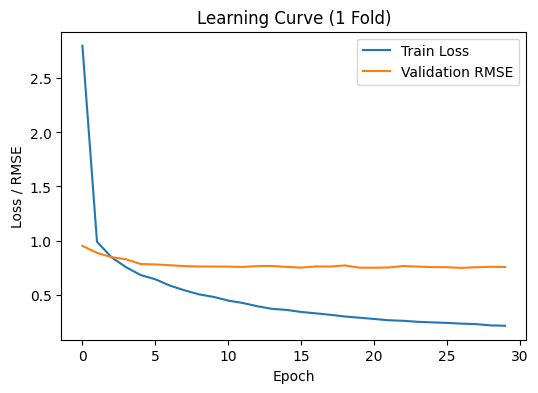

Final Epoch Validation R²: 0.479327


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(iter(kf.split(X)))  # 1 fold だけ試す

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

train_ds = FingerprintDataset(X_train, y_train)
val_ds   = FingerprintDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

# 学習
model, history = train_one_fold_with_logs(
    train_loader, val_loader, input_dim=X.shape[1], epochs=30
)

# --- 損失関数とRMSEの推移をプロット ---
plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_rmse"], label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.legend()
plt.title("Learning Curve (1 Fold)")
plt.show()

# --- 最後のepochでのR²を計算して出力 ---
model.eval()
val_preds, val_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb)
        val_preds.extend(pred.cpu().numpy().flatten().tolist())
        val_true.extend(yb.numpy().flatten().tolist())

final_r2 = r2_score(val_true, val_preds)
print(f"Final Epoch Validation R²: {final_r2:.6f}")


### **実測 vs 予測 散布図**

In [ ]:
model.eval()
val_preds, val_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb)
        val_preds.extend(pred.cpu().numpy())
        val_true.extend(yb.numpy())

plt.figure(figsize=(5,5))
plt.scatter(val_true, val_preds, alpha=0.6)
plt.plot([min(val_true), max(val_true)],
         [min(val_true), max(val_true)], 'r--', label="Ideal")
plt.xlabel("True pGI50")
plt.ylabel("Predicted pGI50")
plt.title("True vs Predicted (1 Fold)")
plt.legend()
plt.show()

# ===== セル分割ここまで =====
